## Project Purpose
This project was made with the intent of understanding network analysis and topic modeling and how these can be applied to real-world scenarios. My current course, social media analytics, has shown me the potential value of understanding group dynamics and this project serves to solidify the application of this valuable skill. Lastly, I would like to delve into the psychology of extremism to better understand the context behind the actions of these bad actors.

Network analysis is a set of integrated techniques to show relationships among actors and to analyze the social structures that are created from these relations. This provides a basis to better understand social phenomena by analyzing these relations.

Topic modeling is a type of statistical model for discovering topics that occur in documents. This technique is frequently used to discover hiddent semantic structures in text.

An important note, ISIL lost all territory in March 2019. While supporters still exist, they are no longer an organization with any leaders. Most of the Twitter users in this dataset are now banned from the platform.

## About the Data
The data are 17,000 tweets from 100+ pro-ISIS profiles from across the world since the November 2015 Paris attacks. The original purpose of the dataset was to gain community insights from Kaggle users to develop counter-measures to extremists working abroad. The dataset has 8 columns:
1. Name
2. Twitter Username
3. Description
4. Location
5. Number of followers at the time the tweet was downloaded
6. Number of statuses by the user when the tweet was downloaded
7. Date and timestamp of tweet
8. The tweet itself

## Content
1. Exploratory data analysis
2. Network analysis
3. Topic modeling
4. Insights into the psychology of extremism

## Imports

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
import networkx as nx
import plotly.graph_objects as go
import networkx as nx
import langid
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

%matplotlib inline
plt.style.use('ggplot')

In [15]:
df = pd.read_csv('tweets.csv')

In [16]:
df.head()

,name,username,description,location,followers,numberstatuses,time,tweets
0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:07,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:27,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:29,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:37,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:45,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...


## 1. Exploratory Data Analysis

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17410 entries, 0 to 17409
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            17410 non-null  object
 1   username        17410 non-null  object
 2   description     14728 non-null  object
 3   location        11432 non-null  object
 4   followers       17410 non-null  int64 
 5   numberstatuses  17410 non-null  int64 
 6   time            17410 non-null  object
 7   tweets          17410 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


There are several thousand missing values for "description" and "location" columns, but otherwise the dataset is complete.

In [18]:
#counting tweets and retweets
retweets = []
originaltweets = []
for user, tweet in zip(df['username'], df['tweets']):
    match = re.search(r'^\bRT\b', tweet)
    if match == None:
        originaltweets.append([user,tweet])
    else:
        retweets.append([user,tweet])   

print('The number of original tweets is ',len(originaltweets),'and the number of retweets is ',len(retweets))

The number of original tweets is  11584 and the number of retweets is  5826


en    14556
ar      742
fr      610
ms      198
id      182
la       85
sw       78
de       75
es       64
nl       57
Name: language, dtype: int64


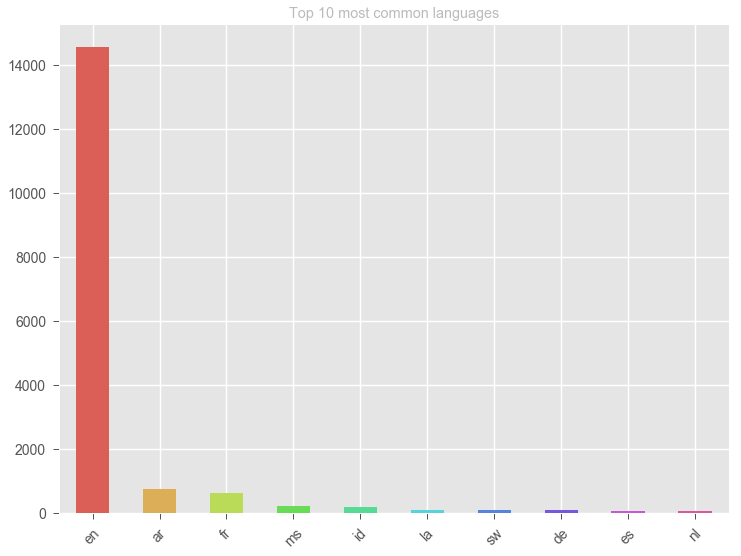

In [25]:
# language distribution

# identify languages
predicted_languages = [langid.classify(tweet) for tweet in df['tweets']]
lang_df = pd.DataFrame(predicted_languages, columns=['language','value'])

# show the top ten languages & their counts
print(lang_df['language'].value_counts().head(10))

# plot the counts for the top ten most commonly used languages
colors=sns.color_palette('hls', 10) 
pd.Series(lang_df['language']).value_counts().head(10).plot(kind = "bar",
                                                        figsize=(12,9),
                                                        color=colors,
                                                        fontsize=14,
                                                        rot=45,
                                                        title = "Top 10 most common languages")

The languages are a large majority English. This is indicative of this dataset and may or may not be representative of the languages spoken on twitter by pro-ISIS members.

<BarContainer object of 2 artists>

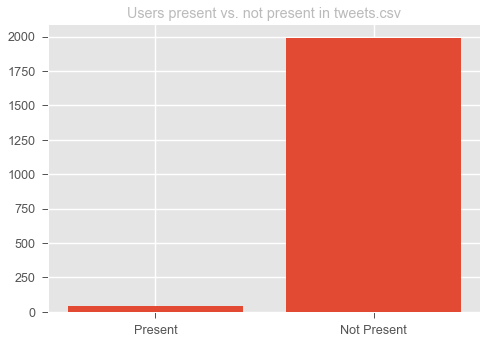

In [45]:
#search for mentioned users who are in tweets.csv
present = []
not_present = []
for record in originaltweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in df['username'].unique()) and (record[0] != name[1:]):
                present.append([record[0], name[1:]])
            elif record[0] != name[1:]:
                not_present.append([record[0], name[1:]])

present = np.array(present)
not_present = np.array(not_present)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Users present vs. not present in tweets.csv')
counts = ['Present', 'Not Present']
values = [len(np.unique(present[:,1])), len(np.unique(not_present[:,1]))]
ax.bar(counts, values)

The large majority of mentions are of users not present in the dataset. Since I am doing a network analysis, I am only concerned with the connections between others within the dataset.

In [32]:
top5_senders = Counter(present[:,0]).most_common(5)
top5_receivers = Counter(present[:,1]).most_common(5)

print('top 5 senders\n-------------\n', top5_senders, '\n')
print('top 5 receivers\n---------------\n', top5_receivers)

top 5 senders
-------------
 [('MaghrabiArabi', 49), ('WarReporter1', 30), ('AsimAbuMerjem', 27), ('Uncle_SamCoco', 27), ('moustiklash', 20)] 

top 5 receivers
---------------
 [('RamiAlLolah', 53), ('Nidalgazaui', 34), ('MilkSheikh2', 26), ('WarReporter1', 15), ('_IshfaqAhmad', 15)]


The top 5 mention receivers seem to be: RamiAlLolah, Nidalgazaui, MilkSheikh2, WarReporter1, and _IshfaqAhmad. Their descriptions may be helpful to gain context on these accounts:

In [48]:
for name, _ in top5_receivers:
    print("Username: {} - {}\n".format(name,
            df[df['username'] == name]['description'].dropna().unique()[0]))

Username: RamiAlLolah - Real-Time News, Exclusives, Intelligence & Classified Information/Reports from the ME. Forecasted many Israeli strikes in Syria/Lebanon. Graphic content.

Username: Nidalgazaui - 17yr. old Freedom Activist
/Correspondence of NGNA /Terror Expert/Middle East Expert. Daily News about Syria/Iraq/Yemen/Russia/Middle East

Username: MilkSheikh2 - Muslim, Iraqi, Banu Zubid, Qahtani, Chef, Engineer, Remaining until the best of them, fights al-Dajjal, Translate Old stuff mostly

Username: WarReporter1 - Reporting on conflicts in the MENA and Asia regions.

Username: _IshfaqAhmad - Medico at GMC Srinagar • Pro-Khilafah • Anti-Democratic • Anti-Nationalistic • Anti-Rafidah • Innocent Bystander of the Conflict in Middle East • Cricketist •



3 of the 5 accounts position themselves as news sources while the other 2 seem to be individuals. Next, I can further this dive into users by connecting them via a network analysis.

## 2. Network Analysis

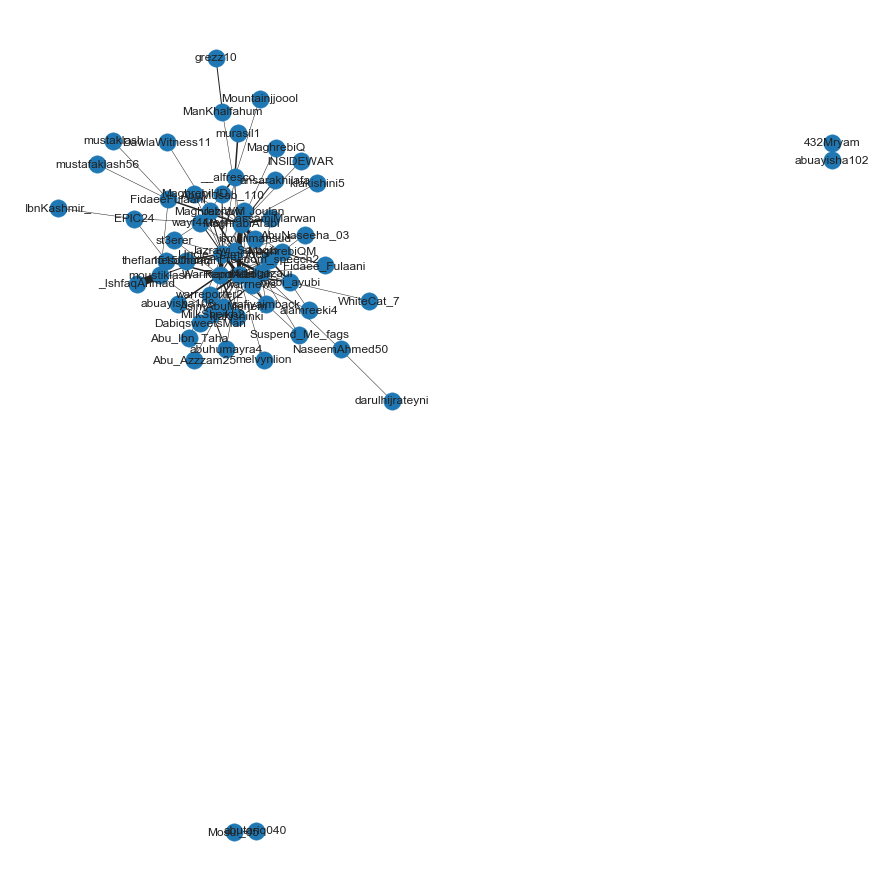

In [51]:
#network
graph=nx.Graph()
all_users = list(set(present[:,0]) | set(present[:,1]))

edges = {}
counter = Counter(map(tuple, present))
for (sender, receiver), count in counter.items():
    if (receiver, sender) in edges.keys():
        edges[(receiver, sender)] = edges[(receiver, sender)] + count
    else:
        edges[(sender, receiver)] = count
        
for (sender, receiver), count in edges.items():
    graph.add_edge(sender, receiver, weight=count)
    
followers = {}
tweet_num = {}
for username in all_users:
    followers[username] = df[df['username'] == username]['followers'].unique()[-1]
    tweet_num[username] = df[df['username'] == username]['tweets'].count()

sizes = [(followers[n] / tweet_num[n]) * 50 for n in graph.nodes()]
weights = [graph[u][v]['weight']/2 for u, v in graph.edges()]

plt.figure(figsize=(12,12))
nx.draw(graph, pos=nx.spring_layout(graph), with_labels=True, width=weights)
plt.show()

In [59]:
import pandas as pd

degree = nx.degree_centrality(graph) # calculate dgree
betweenness = nx.betweenness_centrality(graph) # calculate betweenness
closeness = nx.closeness_centrality(graph) # Calculate closeness

centrality = pd.DataFrame([degree, betweenness, closeness]).T
centrality.reset_index(inplace = True)
centrality.columns = ['Username', 'Degree', 'Betweenness', 'Closeness']
centrality.head()

,Username,Degree,Betweenness,Closeness
0,WhiteCat_7,0.017241,0.000000,0.268855
1,mobi_ayubi,0.103448,0.035598,0.375193
2,MaghrabiArabi,0.327586,0.337685,0.529220
3,Nidalgazaui,0.241379,0.145542,0.492901
4,NaseemAhmed50,0.034483,0.032063,0.328600


Due to the large amount of nodes in the network, the graph is somewhat difficult to interpret. To do so, I have collected 3 metrics of centrality from the network:
1. Degree: Assigns importance based simply on the number of links by a node to other nodes. This is useful to identifying the most popular/connected users.
2. Betweenness: Measures the number of times a node lies on the shortest path between other nodes. This can be useful to identify those who connect disparate parts of the network. A user with high betweenness is important for transmitting new info, ideas, and opportunities to a wide audience.
3. Closeness: Measures how close a node is to all other nodes. This can help identify which users can reach the whole network the fastest.

In [63]:
#top 5 degree centralities
centrality.sort_values(by=['Degree'],ascending=False)[:5]

,Username,Degree,Betweenness,Closeness
2,MaghrabiArabi,0.327586,0.337685,0.529220
6,RamiAlLolah,0.327586,0.252941,0.523707
11,Uncle_SamCoco,0.275862,0.222755,0.513019
3,Nidalgazaui,0.241379,0.145542,0.492901
24,WarReporter1,0.241379,0.112560,0.461246


In [64]:
#top 5 betweenness centralities
centrality.sort_values(by=['Betweenness'],ascending=False)[:5]

,Username,Degree,Betweenness,Closeness
2,MaghrabiArabi,0.327586,0.337685,0.529220
6,RamiAlLolah,0.327586,0.252941,0.523707
11,Uncle_SamCoco,0.275862,0.222755,0.513019
3,Nidalgazaui,0.241379,0.145542,0.492901
24,WarReporter1,0.241379,0.112560,0.461246


In [66]:
#top 5 closeness centralities
centrality.sort_values(by=['Closeness'],ascending=False)[:5]

,Username,Degree,Betweenness,Closeness
2,MaghrabiArabi,0.327586,0.337685,0.529220
6,RamiAlLolah,0.327586,0.252941,0.523707
11,Uncle_SamCoco,0.275862,0.222755,0.513019
3,Nidalgazaui,0.241379,0.145542,0.492901
24,WarReporter1,0.241379,0.112560,0.461246


MaghrabiArabi, RamiAlLolah, Uncle_SamCoCo, Nidalgazaui, and WarReporter1 are the top 5, respectively, for all 3 measures of centrality. This is strong evidence that these 5 actors play a significant role in the pro-ISIS twitter network.

## 4. Topic Modeling

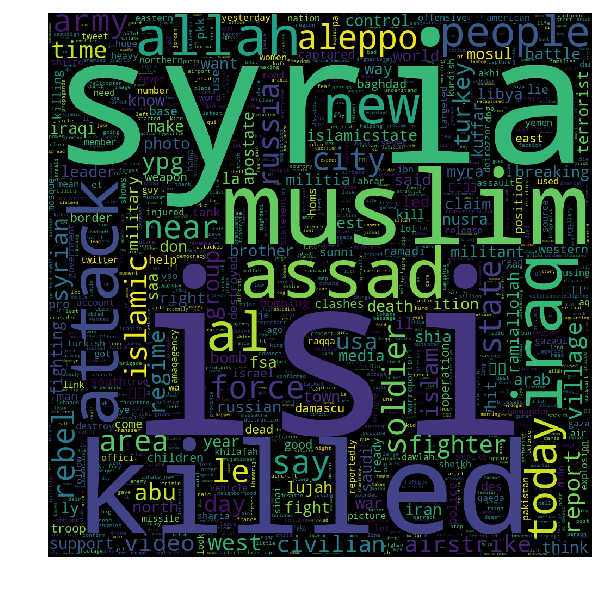

In [50]:
#word cloud
junk = re.compile("al|RT|\n|&.*?;|http[s](?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)*")
tweets = [junk.sub(" ", t) for t in df.tweets]

vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=.5)
tfv = vec.fit_transform(tweets)

terms = vec.get_feature_names()
wc = WordCloud(height=1000, width=1000, max_words=1000).generate(" ".join(terms))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()

I first ran a word cloud to gain some context as to the content users are talking about. From a glance,it seems that users talk the most about war (e.g., "killed" and "attack"), religion (e.g., "muslim" and "allah"), and politics (e.g., "syria" and "assad"). Topic modeling can better help determine the different categories that users are talking about.

In [80]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=8).fit(tfv)
for idx, topic in enumerate(nmf.components_):
    print("Topic #{}:".format(str(idx+1)))
    print(" ".join([terms[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("")

Topic #1:
isis syria ramiallolah iraq assad army breakingnews russia usa turkey

Topic #2:
state islamic islamic state state fighters fighters state forces fighting forces fighting islamic breaking islamic

Topic #3:
nid gazaui gazaui nid gazaui breaking breaking isis saa huge captured soldiers

Topic #4:
killed soldiers army iraqi today soldiers killed sinai lujah near wounded

Topic #5:
aleppo rebels north north aleppo northern northern aleppo syrian ypg countryside turkish

Topic #6:
scotsmaninfidel sassysassyred ele7vn spicylatte123 1_texanna kafirkaty sassysassyred scotsmaninfidel kafirkaty ele7vn scotsmaninfidel 1_texanna jailamx

Topic #7:
islamicstate amaqagency breaking fighters breaking islamicstate forces city amaqagency islamicstate islamicstate fighters martyrdom

Topic #8:
allah al islam abu people akhi qaeda nusra muslims al qaeda



Playing around with the number of topics, the optimal number seems to be around 8 topics. These topics are loosely:
1. Countries involved
2. Islamic state
3. ISIS leaders
4. Fights and skirmishes
5. Rebels
6. Twitter users
7. Islamic state (again)
8. Religion

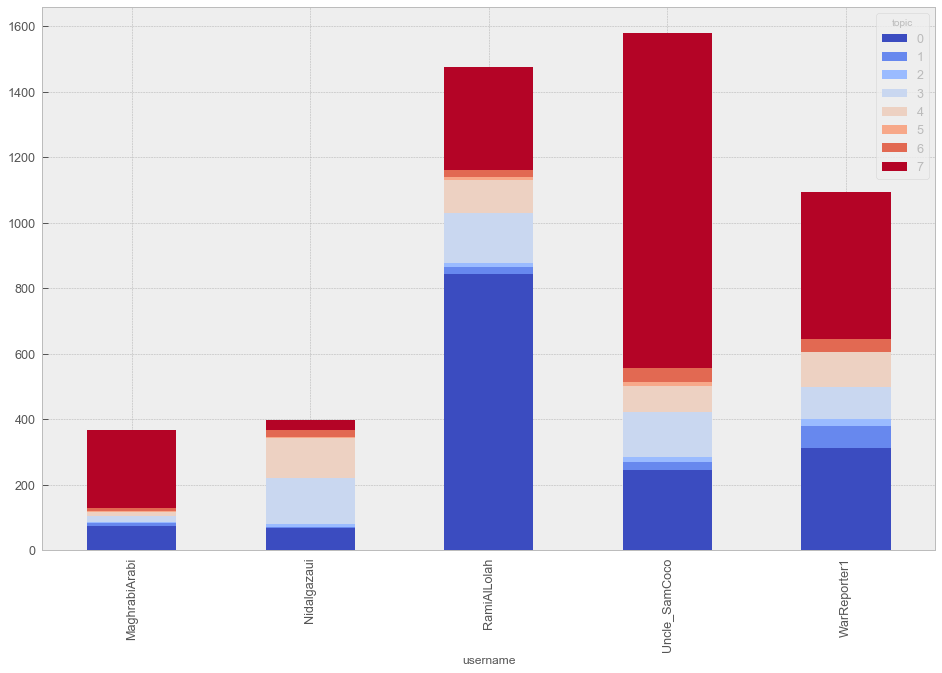

In [95]:
from matplotlib import style

style.use('bmh')

df['topic'] = np.argmax(nmf.transform(vec.transform(tweets)), axis=1)
top5_users = df[df.username.isin(['MaghrabiArabi',
                                   'RamiAlLolah',
                                   'Uncle_SamCoco',
                                   'Nidalgazaui',
                                   'WarReporter1'])]
pd.crosstab(top5_users.username, top5_users.topic).plot.bar(stacked=True, figsize=(16, 10), colormap="coolwarm")

Combining my network analysis and topic modeling, I can create further insights. I can look into the topics that the top 5 most important players I found from the network analysis and analyze the topics that they tend to talk about. Here, we see some interesting trends:
- Uncle_SamCoCo and MaghrabiArabi talk about religion a large majority of the time
- RamiAlLolah talks mostly about countries' involvement. This makes sense as his description includes: "Forecasted many Israeli strikes in Syria/Lebanon."
- WarReporter1 and Nidalgazaui cover a larger spectrum of topics

## 4. Insights into Psychology of Extremism

The purpose of this project was to gain insights into the behavior of Pro-ISIS users on Twitter, but data can only go so far. To gain context on these insights, psychology is needed to understand why these bad actors behave this way in the first place.

Firstly, what is extremism? There is debate as to how to define extremism, but I prefer the definition that states that it is possessing beliefs that in some way increase one's propensity for violoence against other groups and that this behavior occurs within a culture where such violence is not tolerated or expected. This is helpful to isolate the definition of extremism from any particular set of political or religious beliefs.

In a published paper by Andreas Beelmann, ["A Social-Developmental Model of Radicalization: A Systematic Integration of Existing Theories and Empirical Research,"](https://www.ijcv.org/index.php/ijcv/article/view/3778) Beelmann argues that radicalization occurs in 3 steps:
1. Ontogenetic development processes
2. Proximal radicalization processes
3. Extremist attitudes/opinions and behavior/action

In other words, maturity from childhood to adulthood, being near similar actors, and eventually taking on these behaviors. During maturity, Beelmann lists 3 distinct risk factors:
1. Societal risk factors (e.g., real intergroup conflicts, intergroup threats, and the prevalence of ideologies legitimizing violence)
2. Social risk factors (e.g., violence in the home, the experience of group discrimination, minimal social diversity)
3. Individual risk factors (e.g., personality characteristics that favor domination/authoritarianism, self-esteem problems, antisocial behavior)

So, what can we do about these factors? There is no easy solution, but research shows that it is somewhat clear that developmental conditions combined with a lack of protective factors serve as a recipe for individuals to transition into extremism. Immediate action from data insights will help tremendously to detect and stifle extremist activity. However, long-term solutions will require a combination of data, policies, and support geared towards those individuals and communities susceptible to extremism if we are to most effectively tackle the root cause of this problem.